In [1]:
import sys
sys.path.append('../')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from fb_gp import saas_fbgp
import numpy as np
import time
import jax.numpy as jnp
from jax import random,vmap, grad
from jax.lax import while_loop
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from acquisition import EI, IPV, optim_scipy_bh
import scipy.optimize
from scipy.stats import qmc
from jaxns import NestedSampler
import corner
from nested_sampler import nested_sampling_jaxns, nested_sampling_Dy
from getdist import plots,MCSamples,loadMCSamples


matplotlib.rc('font', size=16,family='serif')
matplotlib.rc('legend', fontsize=16)

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/cosmo/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


In [2]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 16
ndim = 4
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)

mean_r = 0.2
scale = 0.02


def f(X):
    r2 = (X[:,0]-0.5)**2 + (X[:,1]-0.4)**2
    r = np.sqrt(r2)
    return -0.5*((r-mean_r)/scale)**2

train_y = f(train_x).reshape(-1,1)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-6)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)

# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
# ax1.scatter(train_x[:,0],train_x[:,1])
# ax1.set_xlabel(r'$x_1$')
# ax1.set_ylabel(r'$x_2$')
# ax2.scatter(train_x[:,2],train_x[:,3])
# ax2.set_xlabel(r'$x_3$')
# ax2.set_ylabel(r'$x_4$')

(16, 4) (16, 1)
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:01<00:00, 759.81it/s, 15 steps of size 2.22e-01. acc. prob=0.81]



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]    101.95    374.64      2.38      0.02    152.12     25.61      1.01
_kernel_inv_length_sq[1]    130.45    290.07      6.42      0.14    483.15     14.71      1.03
_kernel_inv_length_sq[2]      0.71      0.72      0.45      0.03      1.49     16.18      1.03
_kernel_inv_length_sq[3]      0.90      1.07      0.56      0.00      2.41     43.49      1.02
        kernel_length[0]      2.04      3.08      0.61      0.14      5.98     12.15      1.08
        kernel_length[1]      1.03      1.17      0.53      0.11      3.27     13.96      1.11
        kernel_length[2]      4.02      3.88      2.67      0.56      8.57     11.40      0.97
        kernel_length[3]      4.75      7.02      3.34      0.48      7.27     35.12      1.01
            kernel_tausq      0.66      1.32      0.32      0.02      0.99     33.76      1.01
              kernel_var      7.10      6.93     

In [3]:
nsteps = 80 # 32
mc_points_size = 16
start = time.time()


ns_skip = 1
fit_skip = 1

for i in range(nsteps):
    if (i%ns_skip==0):
        samples, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
        print(f"LogZ info :"+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
        size = len(samples)
        mc_points = samples[::int(size/mc_points_size),:]
    acq_func = IPV(gp,mc_points)
    grad_fn = grad(acq_func)
    x0 =  np.random.uniform(0,1,ndim)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x = jnp.atleast_2d(results.x)
    next_y = f((next_x)).reshape(-1,1)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    seed = i
    rng_key, _ = random.split(random.PRNGKey(seed), 2)
    if (i%fit_skip==0):
        gp = saas_fbgp(train_x,train_y,noise=1e-6)
        gp.fit(rng_key,warmup_steps=256,num_samples=256,thinning=16,verbose=False) # change rng key?
    else:
        gp.quick_update(next_x,next_y)
    print(f"----------------------Step {i+1} complete----------------------\n")


print(f"BO took {time.time() - start:.2f} s ")

Nested Sampling took 4.03s
jaxns did 42524 likelihood evaluations
LogZ info :logz_mean: = 5.8379, dlogz: = 0.2980, 
Acquisition optimization took 3.91 s
Next point at x = [0.67942213 0.42074739 0.51131807 0.06966337] with acquisition function value = 0.008786410448754094


sample: 100%|██████████| 512/512 [00:01<00:00, 492.32it/s, 15 steps of size 1.81e-01. acc. prob=0.91]



MCMC elapsed time: 1.49s
----------------------Step 1 complete----------------------

Nested Sampling took 2.54s
jaxns did 36685 likelihood evaluations
LogZ info :logz_mean: = 9.9621, dlogz: = 0.2854, 
Acquisition optimization took 2.64 s
Next point at x = [0.5495826  0.42907919 0.6459051  0.75445313] with acquisition function value = 0.015363246716673383


sample: 100%|██████████| 512/512 [00:01<00:00, 460.38it/s, 7 steps of size 5.25e-01. acc. prob=0.87]



MCMC elapsed time: 1.54s
----------------------Step 2 complete----------------------

Nested Sampling took 2.96s
jaxns did 39121 likelihood evaluations
LogZ info :logz_mean: = 13.7904, dlogz: = 0.3502, 
Acquisition optimization took 4.50 s
Next point at x = [0.15578991 0.19440874 0.96376165 0.00345037] with acquisition function value = 0.0043391471672418365


sample: 100%|██████████| 512/512 [00:01<00:00, 468.37it/s, 31 steps of size 1.77e-01. acc. prob=0.95]



MCMC elapsed time: 1.48s
----------------------Step 3 complete----------------------

Nested Sampling took 2.57s
jaxns did 43560 likelihood evaluations
LogZ info :logz_mean: = 4.5613, dlogz: = 0.3463, 
Acquisition optimization took 4.31 s
Next point at x = [0.35863759 0.15415376 0.25567298 0.02710407] with acquisition function value = 0.0038182189226709518


sample: 100%|██████████| 512/512 [00:01<00:00, 412.59it/s, 7 steps of size 3.52e-01. acc. prob=0.90] 



MCMC elapsed time: 1.64s
----------------------Step 4 complete----------------------

Nested Sampling took 2.60s
jaxns did 34179 likelihood evaluations
LogZ info :logz_mean: = -0.5341, dlogz: = 0.3156, 
Acquisition optimization took 4.13 s
Next point at x = [0.65859657 0.23810371 0.02769776 0.08826712] with acquisition function value = 0.014078564900691624


sample: 100%|██████████| 512/512 [00:00<00:00, 518.71it/s, 15 steps of size 2.34e-01. acc. prob=0.92]



MCMC elapsed time: 1.40s
----------------------Step 5 complete----------------------

Nested Sampling took 2.72s
jaxns did 36079 likelihood evaluations
LogZ info :logz_mean: = -0.6883, dlogz: = 0.3207, 
Acquisition optimization took 3.37 s
Next point at x = [0.28590788 0.45479463 0.94187083 0.04446766] with acquisition function value = 0.0018284847796985922


sample: 100%|██████████| 512/512 [00:00<00:00, 551.83it/s, 15 steps of size 2.06e-01. acc. prob=0.91]



MCMC elapsed time: 1.31s
----------------------Step 6 complete----------------------

Nested Sampling took 2.10s
jaxns did 33460 likelihood evaluations
LogZ info :logz_mean: = -0.1397, dlogz: = 0.3335, 
Acquisition optimization took 3.27 s
Next point at x = [0.44933033 0.08213345 0.95303889 0.02971497] with acquisition function value = 0.0012496469096278722


sample: 100%|██████████| 512/512 [00:01<00:00, 435.24it/s, 7 steps of size 4.51e-01. acc. prob=0.82] 



MCMC elapsed time: 1.61s
----------------------Step 7 complete----------------------

Nested Sampling took 2.62s
jaxns did 31546 likelihood evaluations
LogZ info :logz_mean: = -2.2776, dlogz: = 0.2769, 
Acquisition optimization took 3.79 s
Next point at x = [0.48521954 0.27880112 0.06448314 0.17342428] with acquisition function value = 0.0022417938661964364


sample: 100%|██████████| 512/512 [00:00<00:00, 578.58it/s, 3 steps of size 5.55e-01. acc. prob=0.86]



MCMC elapsed time: 1.30s
----------------------Step 8 complete----------------------

Nested Sampling took 2.16s
jaxns did 37297 likelihood evaluations
LogZ info :logz_mean: = 8.0256, dlogz: = 0.3647, 
Acquisition optimization took 3.00 s
Next point at x = [0.85536305 0.47292968 0.04809329 0.02795771] with acquisition function value = 0.0010769837951403651


sample: 100%|██████████| 512/512 [00:01<00:00, 505.36it/s, 15 steps of size 2.19e-01. acc. prob=0.94]



MCMC elapsed time: 1.69s
----------------------Step 9 complete----------------------

Nested Sampling took 2.15s
jaxns did 36157 likelihood evaluations
LogZ info :logz_mean: = -1.9142, dlogz: = 0.3004, 
Acquisition optimization took 3.67 s
Next point at x = [0.3134878  0.31933358 0.58134552 0.07972285] with acquisition function value = 0.00026012813904923056


sample: 100%|██████████| 512/512 [00:01<00:00, 451.93it/s, 31 steps of size 1.26e-01. acc. prob=0.95]



MCMC elapsed time: 1.58s
----------------------Step 10 complete----------------------

Nested Sampling took 2.24s
jaxns did 36260 likelihood evaluations
LogZ info :logz_mean: = -3.7062, dlogz: = 0.2871, 
Acquisition optimization took 4.67 s
Next point at x = [0.68829544 0.56269916 0.34719377 0.01799443] with acquisition function value = 0.0005513217034401469


sample: 100%|██████████| 512/512 [00:00<00:00, 526.55it/s, 7 steps of size 4.54e-01. acc. prob=0.86] 



MCMC elapsed time: 1.44s
----------------------Step 11 complete----------------------

Nested Sampling took 2.26s
jaxns did 37951 likelihood evaluations
LogZ info :logz_mean: = -3.7029, dlogz: = 0.2852, 
Acquisition optimization took 3.64 s
Next point at x = [0.52160538 0.20523551 0.61442296 0.        ] with acquisition function value = 0.0008860236403987996


sample: 100%|██████████| 512/512 [00:01<00:00, 366.98it/s, 7 steps of size 5.68e-01. acc. prob=0.91] 



MCMC elapsed time: 1.84s
----------------------Step 12 complete----------------------

Nested Sampling took 2.33s
jaxns did 35323 likelihood evaluations
LogZ info :logz_mean: = -3.3716, dlogz: = 0.2936, 
Acquisition optimization took 4.70 s
Next point at x = [0.72755036 0.46478475 0.73532913 0.27683254] with acquisition function value = 0.0006707705692025273


sample: 100%|██████████| 512/512 [00:00<00:00, 564.70it/s, 7 steps of size 4.61e-01. acc. prob=0.91]



MCMC elapsed time: 1.35s
----------------------Step 13 complete----------------------

Nested Sampling took 2.77s
jaxns did 34651 likelihood evaluations
LogZ info :logz_mean: = -3.5589, dlogz: = 0.2871, 
Acquisition optimization took 4.37 s
Next point at x = [0.34773899 0.26717166 0.89627314 0.16331823] with acquisition function value = 0.0001409511245043394


sample: 100%|██████████| 512/512 [00:00<00:00, 531.14it/s, 7 steps of size 5.29e-01. acc. prob=0.89] 



MCMC elapsed time: 1.43s
----------------------Step 14 complete----------------------

Nested Sampling took 2.36s
jaxns did 40465 likelihood evaluations
LogZ info :logz_mean: = -1.9753, dlogz: = 0.2858, 
Acquisition optimization took 4.19 s
Next point at x = [0.35722292 0.57906631 0.68912293 0.76720818] with acquisition function value = 0.0011342300509930413


sample: 100%|██████████| 512/512 [00:00<00:00, 513.12it/s, 3 steps of size 6.00e-01. acc. prob=0.93] 



MCMC elapsed time: 1.45s
----------------------Step 15 complete----------------------

Nested Sampling took 2.28s
jaxns did 32565 likelihood evaluations
LogZ info :logz_mean: = -3.0878, dlogz: = 0.2617, 
Acquisition optimization took 4.48 s
Next point at x = [0.72499468 0.35475209 0.27489359 0.02803599] with acquisition function value = 0.0002698806742301024


sample: 100%|██████████| 512/512 [00:02<00:00, 212.19it/s, 7 steps of size 7.85e-01. acc. prob=0.86] 



MCMC elapsed time: 2.95s
----------------------Step 16 complete----------------------

Nested Sampling took 2.09s
jaxns did 38968 likelihood evaluations
LogZ info :logz_mean: = -3.4386, dlogz: = 0.2687, 
Acquisition optimization took 4.78 s
Next point at x = [0.28509775 0.47673173 0.77604442 0.87659907] with acquisition function value = 0.00013135439711398165


sample: 100%|██████████| 512/512 [00:04<00:00, 106.47it/s, 7 steps of size 6.12e-01. acc. prob=0.92]



MCMC elapsed time: 5.41s
----------------------Step 17 complete----------------------

Nested Sampling took 2.47s
jaxns did 30264 likelihood evaluations
LogZ info :logz_mean: = -3.7325, dlogz: = 0.2718, 
Acquisition optimization took 2.93 s
Next point at x = [0.34271996 0.55635769 0.87568649 0.35496631] with acquisition function value = 8.023112924938295e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 202.77it/s, 7 steps of size 5.51e-01. acc. prob=0.93] 



MCMC elapsed time: 3.16s
----------------------Step 18 complete----------------------

Nested Sampling took 2.00s
jaxns did 31903 likelihood evaluations
LogZ info :logz_mean: = -3.7951, dlogz: = 0.2708, 
Acquisition optimization took 2.18 s
Next point at x = [0.42734147 0.22034915 0.25752782 0.01493152] with acquisition function value = 4.857701099561865e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 182.92it/s, 7 steps of size 6.93e-01. acc. prob=0.87] 



MCMC elapsed time: 3.39s
----------------------Step 19 complete----------------------

Nested Sampling took 2.49s
jaxns did 29458 likelihood evaluations
LogZ info :logz_mean: = -3.7105, dlogz: = 0.2615, 
Acquisition optimization took 1.75 s
Next point at x = [3.26328248e-01 4.78223398e-01 3.28507238e-04 6.42800933e-01] with acquisition function value = 4.015328673178005e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 204.65it/s, 7 steps of size 7.86e-01. acc. prob=0.87] 



MCMC elapsed time: 3.07s
----------------------Step 20 complete----------------------

Nested Sampling took 2.04s
jaxns did 34442 likelihood evaluations
LogZ info :logz_mean: = -3.3882, dlogz: = 0.2649, 
Acquisition optimization took 2.06 s
Next point at x = [0.30550466 0.42940091 0.82829282 0.9456464 ] with acquisition function value = 6.062600446416627e-05


sample: 100%|██████████| 512/512 [00:03<00:00, 168.95it/s, 3 steps of size 6.87e-01. acc. prob=0.89] 



MCMC elapsed time: 3.74s
----------------------Step 21 complete----------------------

Nested Sampling took 2.88s
jaxns did 41766 likelihood evaluations
LogZ info :logz_mean: = 0.3343, dlogz: = 0.3152, 
Acquisition optimization took 4.01 s
Next point at x = [0.36095965 0.20189733 0.28926526 0.94039644] with acquisition function value = 0.00010967075048333094


sample: 100%|██████████| 512/512 [00:02<00:00, 187.38it/s, 7 steps of size 5.96e-01. acc. prob=0.90] 



MCMC elapsed time: 3.31s
----------------------Step 22 complete----------------------

Nested Sampling took 1.91s
jaxns did 31025 likelihood evaluations
LogZ info :logz_mean: = -3.0830, dlogz: = 0.2538, 
Acquisition optimization took 4.09 s
Next point at x = [0.4239486  0.58982953 0.3616646  0.13611368] with acquisition function value = 9.178374451336221e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 205.80it/s, 7 steps of size 5.93e-01. acc. prob=0.92] 



MCMC elapsed time: 3.12s
----------------------Step 23 complete----------------------

Nested Sampling took 1.95s
jaxns did 30881 likelihood evaluations
LogZ info :logz_mean: = -3.1541, dlogz: = 0.2583, 
Acquisition optimization took 0.99 s
Next point at x = [0.32057542 0.31724474 0.8159499  0.44313957] with acquisition function value = 4.30742751389079e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 191.42it/s, 7 steps of size 5.00e-01. acc. prob=0.94] 



MCMC elapsed time: 3.43s
----------------------Step 24 complete----------------------

Nested Sampling took 1.90s
jaxns did 31809 likelihood evaluations
LogZ info :logz_mean: = -3.2191, dlogz: = 0.2607, 
Acquisition optimization took 2.51 s
Next point at x = [0.47673631 0.61213354 0.23093082 0.1518334 ] with acquisition function value = 6.400310629208449e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 189.99it/s, 7 steps of size 6.94e-01. acc. prob=0.87] 



MCMC elapsed time: 3.24s
----------------------Step 25 complete----------------------

Nested Sampling took 2.60s
jaxns did 29206 likelihood evaluations
LogZ info :logz_mean: = -3.0846, dlogz: = 0.2440, 
Acquisition optimization took 0.92 s
Next point at x = [0.39244725 0.14453389 0.00763458 0.59641936] with acquisition function value = 2.4638378140581785e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 187.26it/s, 7 steps of size 6.13e-01. acc. prob=0.93] 



MCMC elapsed time: 3.40s
----------------------Step 26 complete----------------------

Nested Sampling took 1.94s
jaxns did 29887 likelihood evaluations
LogZ info :logz_mean: = -3.3361, dlogz: = 0.2581, 
Acquisition optimization took 0.80 s
Next point at x = [0.23502764 0.21689381 0.14429818 0.51781267] with acquisition function value = 2.3250852342393546e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 183.03it/s, 7 steps of size 5.71e-01. acc. prob=0.93]



MCMC elapsed time: 3.44s
----------------------Step 27 complete----------------------

Nested Sampling took 1.97s
jaxns did 30867 likelihood evaluations
LogZ info :logz_mean: = -3.0968, dlogz: = 0.2515, 
Acquisition optimization took 0.83 s
Next point at x = [0.87836613 0.46506781 0.40001089 0.07617071] with acquisition function value = 2.032812650984081e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 173.97it/s, 7 steps of size 6.62e-01. acc. prob=0.92] 



MCMC elapsed time: 3.63s
----------------------Step 28 complete----------------------

Nested Sampling took 1.94s
jaxns did 31058 likelihood evaluations
LogZ info :logz_mean: = -3.1582, dlogz: = 0.2541, 
Acquisition optimization took 0.90 s
Next point at x = [0.48040113 0.61505658 0.3223273  0.94226665] with acquisition function value = 1.2116611825761445e-05


sample: 100%|██████████| 512/512 [00:03<00:00, 160.16it/s, 7 steps of size 6.48e-01. acc. prob=0.90] 



MCMC elapsed time: 3.82s
----------------------Step 29 complete----------------------

Nested Sampling took 1.99s
jaxns did 29120 likelihood evaluations
LogZ info :logz_mean: = -2.8258, dlogz: = 0.2537, 
Acquisition optimization took 0.85 s
Next point at x = [0.38634452 0.50162805 0.72297852 0.9937494 ] with acquisition function value = 1.993074356994827e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 193.35it/s, 7 steps of size 5.84e-01. acc. prob=0.93]



MCMC elapsed time: 3.22s
----------------------Step 30 complete----------------------

Nested Sampling took 1.97s
jaxns did 31694 likelihood evaluations
LogZ info :logz_mean: = -3.0632, dlogz: = 0.2555, 
Acquisition optimization took 0.81 s
Next point at x = [0.82658547 0.39813607 0.99999923 0.80873914] with acquisition function value = 2.9751149634682852e-05


sample: 100%|██████████| 512/512 [00:03<00:00, 163.97it/s, 7 steps of size 5.87e-01. acc. prob=0.94] 



MCMC elapsed time: 4.57s
----------------------Step 31 complete----------------------

Nested Sampling took 2.05s
jaxns did 33039 likelihood evaluations
LogZ info :logz_mean: = -3.1278, dlogz: = 0.2596, 
Acquisition optimization took 0.84 s
Next point at x = [0.50703027 0.50589496 0.25924367 0.6649512 ] with acquisition function value = 1.9120951176178694e-05


sample: 100%|██████████| 512/512 [00:03<00:00, 162.90it/s, 7 steps of size 7.45e-01. acc. prob=0.89] 



MCMC elapsed time: 3.75s
----------------------Step 32 complete----------------------

Nested Sampling took 2.10s
jaxns did 33015 likelihood evaluations
LogZ info :logz_mean: = -3.0091, dlogz: = 0.2548, 
Acquisition optimization took 0.86 s
Next point at x = [0.56324969 0.37144567 0.68562826 1.        ] with acquisition function value = 1.8990409985458756e-05


sample: 100%|██████████| 512/512 [00:04<00:00, 114.78it/s, 7 steps of size 4.55e-01. acc. prob=0.86] 



MCMC elapsed time: 5.12s
----------------------Step 33 complete----------------------

Nested Sampling took 2.13s
jaxns did 42630 likelihood evaluations
LogZ info :logz_mean: = 1.2863, dlogz: = 0.3098, 
Acquisition optimization took 5.20 s
Next point at x = [0.63251669 0.22422521 0.60530254 0.93500454] with acquisition function value = 0.00014980568530153712


sample: 100%|██████████| 512/512 [00:03<00:00, 163.83it/s, 7 steps of size 6.17e-01. acc. prob=0.90] 



MCMC elapsed time: 3.72s
----------------------Step 34 complete----------------------

Nested Sampling took 2.46s
jaxns did 64848 likelihood evaluations
LogZ info :logz_mean: = -0.3691, dlogz: = 0.3131, 
Acquisition optimization took 4.82 s
Next point at x = [0.39504189 0.99781697 0.5005834  0.60605502] with acquisition function value = 0.0019136860654369583


sample: 100%|██████████| 512/512 [00:03<00:00, 136.18it/s, 7 steps of size 6.38e-01. acc. prob=0.89] 



MCMC elapsed time: 4.52s
----------------------Step 35 complete----------------------

Nested Sampling took 2.36s
jaxns did 44174 likelihood evaluations
LogZ info :logz_mean: = -1.5027, dlogz: = 0.2773, 
Acquisition optimization took 2.30 s
Next point at x = [0.5674406  0.58833475 0.37567765 0.35326847] with acquisition function value = 2.398115455772183e-05


sample: 100%|██████████| 512/512 [00:03<00:00, 135.47it/s, 7 steps of size 6.40e-01. acc. prob=0.90] 



MCMC elapsed time: 4.43s
----------------------Step 36 complete----------------------

Nested Sampling took 2.15s
jaxns did 33506 likelihood evaluations
LogZ info :logz_mean: = -2.4706, dlogz: = 0.2523, 
Acquisition optimization took 1.01 s
Next point at x = [0.7684069  0.38738748 0.         0.60005528] with acquisition function value = 2.1645449344420004e-05


sample: 100%|██████████| 512/512 [00:03<00:00, 129.22it/s, 7 steps of size 5.97e-01. acc. prob=0.91] 



MCMC elapsed time: 4.68s
----------------------Step 37 complete----------------------

Nested Sampling took 3.03s
jaxns did 37643 likelihood evaluations
LogZ info :logz_mean: = -2.4423, dlogz: = 0.2523, 
Acquisition optimization took 0.93 s
Next point at x = [0.45922103 0.62318277 0.65671368 0.61205204] with acquisition function value = 2.0174238460067204e-05


sample: 100%|██████████| 512/512 [00:03<00:00, 161.36it/s, 7 steps of size 5.82e-01. acc. prob=0.90] 



MCMC elapsed time: 3.77s
----------------------Step 38 complete----------------------

Nested Sampling took 2.08s
jaxns did 32954 likelihood evaluations
LogZ info :logz_mean: = -2.5220, dlogz: = 0.2467, 
Acquisition optimization took 1.08 s
Next point at x = [0.66150792 0.22361768 0.76501013 0.57958883] with acquisition function value = 2.5142190903624205e-05


sample: 100%|██████████| 512/512 [00:03<00:00, 144.12it/s, 7 steps of size 6.27e-01. acc. prob=0.89]



MCMC elapsed time: 4.22s
----------------------Step 39 complete----------------------

Nested Sampling took 2.11s
jaxns did 37805 likelihood evaluations
LogZ info :logz_mean: = -2.3446, dlogz: = 0.2417, 
Acquisition optimization took 3.81 s
Next point at x = [0.69593953 0.03122652 0.62184125 0.51939169] with acquisition function value = 1.8048032310152493e-05


sample: 100%|██████████| 512/512 [00:03<00:00, 158.31it/s, 7 steps of size 7.33e-01. acc. prob=0.88] 



MCMC elapsed time: 3.86s
----------------------Step 40 complete----------------------

Nested Sampling took 2.06s
jaxns did 34208 likelihood evaluations
LogZ info :logz_mean: = -2.4507, dlogz: = 0.2501, 
Acquisition optimization took 1.00 s
Next point at x = [0.50377318 0.57899615 0.91665475 0.43749456] with acquisition function value = 8.408782420108417e-06


sample: 100%|██████████| 512/512 [00:04<00:00, 123.97it/s, 7 steps of size 5.84e-01. acc. prob=0.92] 



MCMC elapsed time: 4.77s
----------------------Step 41 complete----------------------

Nested Sampling took 2.18s
jaxns did 31352 likelihood evaluations
LogZ info :logz_mean: = -2.5220, dlogz: = 0.2436, 
Acquisition optimization took 0.91 s
Next point at x = [0.68576316 0.44292909 0.85520976 0.34467123] with acquisition function value = 1.0304639361570674e-05


sample: 100%|██████████| 512/512 [00:04<00:00, 123.42it/s, 7 steps of size 5.60e-01. acc. prob=0.93] 



MCMC elapsed time: 4.88s
----------------------Step 42 complete----------------------

Nested Sampling took 3.30s
jaxns did 34222 likelihood evaluations
LogZ info :logz_mean: = -2.4126, dlogz: = 0.2409, 
Acquisition optimization took 1.06 s
Next point at x = [6.64142699e-01 3.31136093e-01 9.30878668e-07 6.18143582e-01] with acquisition function value = 8.08221570045009e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 136.32it/s, 7 steps of size 5.46e-01. acc. prob=0.93] 



MCMC elapsed time: 4.47s
----------------------Step 43 complete----------------------

Nested Sampling took 2.63s
jaxns did 29875 likelihood evaluations
LogZ info :logz_mean: = -2.4295, dlogz: = 0.2418, 
Acquisition optimization took 0.84 s
Next point at x = [0.22713415 0.44105854 0.72563725 0.6092679 ] with acquisition function value = 8.136823353266376e-06


sample: 100%|██████████| 512/512 [00:04<00:00, 103.72it/s, 7 steps of size 6.44e-01. acc. prob=0.90] 



MCMC elapsed time: 5.59s
----------------------Step 44 complete----------------------

Nested Sampling took 2.08s
jaxns did 32685 likelihood evaluations
LogZ info :logz_mean: = -2.5426, dlogz: = 0.2429, 
Acquisition optimization took 1.93 s
Next point at x = [0.47538613 0.67340925 0.20044814 0.32881773] with acquisition function value = 1.4477060381230984e-05


sample: 100%|██████████| 512/512 [00:04<00:00, 113.40it/s, 7 steps of size 5.25e-01. acc. prob=0.93] 



MCMC elapsed time: 5.23s
----------------------Step 45 complete----------------------

Nested Sampling took 2.20s
jaxns did 32776 likelihood evaluations
LogZ info :logz_mean: = -2.3865, dlogz: = 0.2433, 
Acquisition optimization took 0.90 s
Next point at x = [0.38131542 0.27662458 0.61013145 0.59996876] with acquisition function value = 1.5796956297341007e-05


sample: 100%|██████████| 512/512 [00:05<00:00, 95.26it/s, 3 steps of size 6.63e-01. acc. prob=0.90]  



MCMC elapsed time: 6.14s
----------------------Step 46 complete----------------------

Nested Sampling took 2.24s
jaxns did 29544 likelihood evaluations
LogZ info :logz_mean: = -2.4801, dlogz: = 0.2399, 
Acquisition optimization took 0.94 s
Next point at x = [0.59692176 0.65856127 0.         0.74536563] with acquisition function value = 7.530617451965808e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 136.61it/s, 7 steps of size 4.82e-01. acc. prob=0.92] 



MCMC elapsed time: 4.42s
----------------------Step 47 complete----------------------

Nested Sampling took 1.96s
jaxns did 29073 likelihood evaluations
LogZ info :logz_mean: = -2.4566, dlogz: = 0.2376, 
Acquisition optimization took 1.65 s
Next point at x = [0.61839842 0.2703966  0.94334499 0.90225649] with acquisition function value = 4.981120027472592e-06


sample: 100%|██████████| 512/512 [00:05<00:00, 87.58it/s, 7 steps of size 6.30e-01. acc. prob=0.89]  



MCMC elapsed time: 6.69s
----------------------Step 48 complete----------------------

Nested Sampling took 2.16s
jaxns did 31264 likelihood evaluations
LogZ info :logz_mean: = -2.4550, dlogz: = 0.2339, 
Acquisition optimization took 1.85 s
Next point at x = [0.66664211 0.39276378 0.53415234 1.        ] with acquisition function value = 3.881638534852447e-06


sample: 100%|██████████| 512/512 [00:05<00:00, 92.88it/s, 7 steps of size 8.13e-01. acc. prob=0.85]  



MCMC elapsed time: 6.55s
----------------------Step 49 complete----------------------

Nested Sampling took 2.08s
jaxns did 31222 likelihood evaluations
LogZ info :logz_mean: = -2.4138, dlogz: = 0.2365, 
Acquisition optimization took 1.75 s
Next point at x = [0.58466536 0.62024719 0.48389738 0.82064613] with acquisition function value = 3.5407377552768016e-06


sample: 100%|██████████| 512/512 [00:06<00:00, 74.63it/s, 7 steps of size 6.31e-01. acc. prob=0.92]  



MCMC elapsed time: 7.91s
----------------------Step 50 complete----------------------

Nested Sampling took 2.32s
jaxns did 30747 likelihood evaluations
LogZ info :logz_mean: = -2.3790, dlogz: = 0.2352, 
Acquisition optimization took 1.63 s
Next point at x = [0.45293595 0.100067   0.33760995 0.65895645] with acquisition function value = 5.98792033142375e-06


sample: 100%|██████████| 512/512 [00:06<00:00, 76.09it/s, 7 steps of size 7.39e-01. acc. prob=0.88] 



MCMC elapsed time: 7.78s
----------------------Step 51 complete----------------------

Nested Sampling took 2.41s
jaxns did 32519 likelihood evaluations
LogZ info :logz_mean: = -2.4957, dlogz: = 0.2395, 
Acquisition optimization took 1.70 s
Next point at x = [0.60449076 0.13066322 0.15145244 0.63888493] with acquisition function value = 3.011560522611645e-06


sample: 100%|██████████| 512/512 [00:05<00:00, 94.37it/s, 7 steps of size 6.80e-01. acc. prob=0.86]  



MCMC elapsed time: 6.30s
----------------------Step 52 complete----------------------

Nested Sampling took 2.32s
jaxns did 30595 likelihood evaluations
LogZ info :logz_mean: = -2.4531, dlogz: = 0.2376, 
Acquisition optimization took 2.05 s
Next point at x = [0.37439478 0.20298606 0.53361297 0.9976134 ] with acquisition function value = 3.5645596958471318e-06


sample: 100%|██████████| 512/512 [00:06<00:00, 75.05it/s, 7 steps of size 6.71e-01. acc. prob=0.89]  



MCMC elapsed time: 7.84s
----------------------Step 53 complete----------------------

Nested Sampling took 3.97s
jaxns did 32522 likelihood evaluations
LogZ info :logz_mean: = -2.4302, dlogz: = 0.2366, 
Acquisition optimization took 1.79 s
Next point at x = [0.72901373 0.42600382 0.16243364 0.49233678] with acquisition function value = 2.7706073356774386e-06


sample: 100%|██████████| 512/512 [00:07<00:00, 71.41it/s, 7 steps of size 6.16e-01. acc. prob=0.90]  



MCMC elapsed time: 8.13s
----------------------Step 54 complete----------------------

Nested Sampling took 2.37s
jaxns did 31494 likelihood evaluations
LogZ info :logz_mean: = -2.5697, dlogz: = 0.2367, 
Acquisition optimization took 1.69 s
Next point at x = [0.75695732 0.61666577 1.         0.68109871] with acquisition function value = 3.7466603087267514e-06


sample: 100%|██████████| 512/512 [00:06<00:00, 77.79it/s, 7 steps of size 5.47e-01. acc. prob=0.93]  



MCMC elapsed time: 7.63s
----------------------Step 55 complete----------------------

Nested Sampling took 2.49s
jaxns did 30775 likelihood evaluations
LogZ info :logz_mean: = -2.6187, dlogz: = 0.2407, 
Acquisition optimization took 1.58 s
Next point at x = [0.19981978 0.8845145  0.68283766 0.82808684] with acquisition function value = 2.7012030528999337e-06


sample: 100%|██████████| 512/512 [00:06<00:00, 82.26it/s, 7 steps of size 5.62e-01. acc. prob=0.93]  



MCMC elapsed time: 7.11s
----------------------Step 56 complete----------------------

Nested Sampling took 2.36s
jaxns did 30666 likelihood evaluations
LogZ info :logz_mean: = -2.5694, dlogz: = 0.2408, 
Acquisition optimization took 2.01 s
Next point at x = [0.60334007 0.18089251 0.08829726 0.51382194] with acquisition function value = 4.525582885026719e-06


sample: 100%|██████████| 512/512 [00:06<00:00, 76.78it/s, 7 steps of size 6.26e-01. acc. prob=0.90]  



MCMC elapsed time: 7.70s
----------------------Step 57 complete----------------------

Nested Sampling took 2.33s
jaxns did 30530 likelihood evaluations
LogZ info :logz_mean: = -2.5511, dlogz: = 0.2386, 
Acquisition optimization took 2.15 s
Next point at x = [0.51024979 0.11864168 0.39728291 1.        ] with acquisition function value = 4.8503279914107605e-06


sample: 100%|██████████| 512/512 [00:07<00:00, 65.03it/s, 7 steps of size 7.49e-01. acc. prob=0.90]  



MCMC elapsed time: 8.98s
----------------------Step 58 complete----------------------

Nested Sampling took 2.44s
jaxns did 31941 likelihood evaluations
LogZ info :logz_mean: = -2.6035, dlogz: = 0.2418, 
Acquisition optimization took 1.84 s
Next point at x = [0.37236897 0.39180066 0.62913489 0.10517575] with acquisition function value = 2.5524817522520893e-06


sample: 100%|██████████| 512/512 [00:07<00:00, 73.09it/s, 7 steps of size 5.68e-01. acc. prob=0.93] 



MCMC elapsed time: 7.99s
----------------------Step 59 complete----------------------

Nested Sampling took 2.20s
jaxns did 30628 likelihood evaluations
LogZ info :logz_mean: = -2.6260, dlogz: = 0.2416, 
Acquisition optimization took 1.71 s
Next point at x = [0.78900217 0.70448642 0.74053271 0.27034084] with acquisition function value = 2.800952169730933e-06


sample: 100%|██████████| 512/512 [00:05<00:00, 96.11it/s, 7 steps of size 5.98e-01. acc. prob=0.91]  



MCMC elapsed time: 6.17s
----------------------Step 60 complete----------------------

Nested Sampling took 2.15s
jaxns did 31320 likelihood evaluations
LogZ info :logz_mean: = -2.6167, dlogz: = 0.2417, 
Acquisition optimization took 1.76 s
Next point at x = [0.37485511 0.53402906 0.65665635 0.54297758] with acquisition function value = 3.071566008026362e-06


sample: 100%|██████████| 512/512 [00:06<00:00, 78.98it/s, 7 steps of size 6.65e-01. acc. prob=0.90]  



MCMC elapsed time: 7.41s
----------------------Step 61 complete----------------------

Nested Sampling took 2.24s
jaxns did 31328 likelihood evaluations
LogZ info :logz_mean: = -2.5237, dlogz: = 0.2395, 
Acquisition optimization took 2.26 s
Next point at x = [0.33298379 0.29891809 0.22157035 0.81341315] with acquisition function value = 2.4206153301006145e-06


sample: 100%|██████████| 512/512 [00:07<00:00, 73.04it/s, 7 steps of size 5.00e-01. acc. prob=0.92]  



MCMC elapsed time: 8.00s
----------------------Step 62 complete----------------------

Nested Sampling took 2.29s
jaxns did 32051 likelihood evaluations
LogZ info :logz_mean: = -2.5875, dlogz: = 0.2394, 
Acquisition optimization took 3.32 s
Next point at x = [0.38116579 0.75057924 0.34241734 0.97207387] with acquisition function value = 2.763245604528279e-06


sample: 100%|██████████| 512/512 [00:08<00:00, 63.89it/s, 7 steps of size 6.60e-01. acc. prob=0.93]  



MCMC elapsed time: 9.06s
----------------------Step 63 complete----------------------

Nested Sampling took 2.28s
jaxns did 31955 likelihood evaluations
LogZ info :logz_mean: = -2.4684, dlogz: = 0.2372, 
Acquisition optimization took 1.97 s
Next point at x = [0.14565979 0.41238236 0.76086379 0.84231212] with acquisition function value = 1.5176977085137183e-06


sample: 100%|██████████| 512/512 [00:06<00:00, 78.92it/s, 3 steps of size 5.16e-01. acc. prob=0.90]  



MCMC elapsed time: 7.45s
----------------------Step 64 complete----------------------

Nested Sampling took 2.32s
jaxns did 31172 likelihood evaluations
LogZ info :logz_mean: = -2.6170, dlogz: = 0.2427, 
Acquisition optimization took 1.79 s
Next point at x = [0.70403092 0.30192567 0.77253359 1.        ] with acquisition function value = 2.459946668701557e-06


sample: 100%|██████████| 512/512 [00:06<00:00, 79.46it/s, 7 steps of size 6.28e-01. acc. prob=0.90]  



MCMC elapsed time: 7.40s
----------------------Step 65 complete----------------------

Nested Sampling took 2.32s
jaxns did 32189 likelihood evaluations
LogZ info :logz_mean: = -2.4834, dlogz: = 0.2377, 
Acquisition optimization took 1.95 s
Next point at x = [0.44478141 0.22374351 0.97943213 0.71948761] with acquisition function value = 1.6671207965345686e-06


sample: 100%|██████████| 512/512 [00:07<00:00, 72.71it/s, 7 steps of size 5.63e-01. acc. prob=0.93]  



MCMC elapsed time: 8.03s
----------------------Step 66 complete----------------------

Nested Sampling took 2.19s
jaxns did 31472 likelihood evaluations
LogZ info :logz_mean: = -2.4698, dlogz: = 0.2383, 
Acquisition optimization took 1.89 s
Next point at x = [0.81124155 0.69811704 1.         0.18438014] with acquisition function value = 1.532548847852852e-06


sample: 100%|██████████| 512/512 [00:06<00:00, 83.38it/s, 7 steps of size 7.23e-01. acc. prob=0.86]  



MCMC elapsed time: 7.06s
----------------------Step 67 complete----------------------

Nested Sampling took 3.11s
jaxns did 27333 likelihood evaluations
LogZ info :logz_mean: = -2.3583, dlogz: = 0.2353, 
Acquisition optimization took 2.39 s
Next point at x = [0.31782854 0.56455719 1.         0.55672236] with acquisition function value = 1.5743310220221393e-06


sample: 100%|██████████| 512/512 [00:08<00:00, 63.24it/s, 7 steps of size 5.88e-01. acc. prob=0.92]  



MCMC elapsed time: 9.24s
----------------------Step 68 complete----------------------

Nested Sampling took 2.56s
jaxns did 31379 likelihood evaluations
LogZ info :logz_mean: = -2.5300, dlogz: = 0.2400, 
Acquisition optimization took 2.19 s
Next point at x = [0.34218058 0.47388629 0.7892851  0.        ] with acquisition function value = 1.5176276188435395e-06


sample: 100%|██████████| 512/512 [00:07<00:00, 67.59it/s, 7 steps of size 5.67e-01. acc. prob=0.92] 



MCMC elapsed time: 8.58s
----------------------Step 69 complete----------------------

Nested Sampling took 2.66s
jaxns did 32006 likelihood evaluations
LogZ info :logz_mean: = -2.4462, dlogz: = 0.2372, 
Acquisition optimization took 1.94 s
Next point at x = [0.37663305 0.6186693  0.41019511 0.35552436] with acquisition function value = 1.2234645376512504e-06


sample: 100%|██████████| 512/512 [00:09<00:00, 54.80it/s, 7 steps of size 5.30e-01. acc. prob=0.93] 



MCMC elapsed time: 10.39s
----------------------Step 70 complete----------------------

Nested Sampling took 2.35s
jaxns did 31566 likelihood evaluations
LogZ info :logz_mean: = -2.4853, dlogz: = 0.2401, 
Acquisition optimization took 2.20 s
Next point at x = [0.7019814  0.77900599 0.70428445 0.        ] with acquisition function value = 1.667234780979715e-06


sample: 100%|██████████| 512/512 [00:10<00:00, 47.81it/s, 7 steps of size 6.30e-01. acc. prob=0.92] 



MCMC elapsed time: 11.93s
----------------------Step 71 complete----------------------

Nested Sampling took 2.30s
jaxns did 31812 likelihood evaluations
LogZ info :logz_mean: = -2.5106, dlogz: = 0.2405, 
Acquisition optimization took 2.10 s
Next point at x = [0.76831589 0.36822586 0.49142224 0.87231857] with acquisition function value = 1.0982517678892467e-06


sample: 100%|██████████| 512/512 [00:08<00:00, 57.15it/s, 7 steps of size 6.18e-01. acc. prob=0.91]  



MCMC elapsed time: 10.09s
----------------------Step 72 complete----------------------

Nested Sampling took 2.61s
jaxns did 31969 likelihood evaluations
LogZ info :logz_mean: = -2.5765, dlogz: = 0.2418, 
Acquisition optimization took 1.96 s
Next point at x = [0.09488899 0.38798254 0.1106361  0.61491035] with acquisition function value = 1.949496797312711e-06


sample: 100%|██████████| 512/512 [00:10<00:00, 47.22it/s, 7 steps of size 6.70e-01. acc. prob=0.87]  



MCMC elapsed time: 11.82s
----------------------Step 73 complete----------------------

Nested Sampling took 2.51s
jaxns did 30962 likelihood evaluations
LogZ info :logz_mean: = -2.5725, dlogz: = 0.2411, 
Acquisition optimization took 2.21 s
Next point at x = [0.54233502 0.75016573 0.79841232 0.        ] with acquisition function value = 1.7001274374289777e-06


sample: 100%|██████████| 512/512 [00:11<00:00, 46.16it/s, 7 steps of size 7.12e-01. acc. prob=0.89] 



MCMC elapsed time: 12.18s
----------------------Step 74 complete----------------------

Nested Sampling took 2.56s
jaxns did 31234 likelihood evaluations
LogZ info :logz_mean: = -2.4217, dlogz: = 0.2386, 
Acquisition optimization took 2.08 s
Next point at x = [0.85545185 0.20395211 0.0897889  0.91504973] with acquisition function value = 1.7240039936281676e-06


sample: 100%|██████████| 512/512 [00:08<00:00, 59.44it/s, 7 steps of size 6.06e-01. acc. prob=0.91]  



MCMC elapsed time: 9.64s
----------------------Step 75 complete----------------------

Nested Sampling took 2.52s
jaxns did 31198 likelihood evaluations
LogZ info :logz_mean: = -2.4442, dlogz: = 0.2405, 
Acquisition optimization took 2.00 s
Next point at x = [0.49776462 0.34000858 0.         0.89711454] with acquisition function value = 1.365740064341106e-06


sample: 100%|██████████| 512/512 [00:08<00:00, 58.81it/s, 7 steps of size 6.27e-01. acc. prob=0.91] 



MCMC elapsed time: 9.81s
----------------------Step 76 complete----------------------

Nested Sampling took 2.26s
jaxns did 29552 likelihood evaluations
LogZ info :logz_mean: = -2.3435, dlogz: = 0.2322, 
Acquisition optimization took 2.01 s
Next point at x = [0.65676529 0.49025348 0.05658492 0.31258146] with acquisition function value = 2.1125166910929832e-06


sample: 100%|██████████| 512/512 [00:08<00:00, 57.58it/s, 7 steps of size 5.95e-01. acc. prob=0.91]  



MCMC elapsed time: 9.90s
----------------------Step 77 complete----------------------

Nested Sampling took 2.20s
jaxns did 28905 likelihood evaluations
LogZ info :logz_mean: = -2.4717, dlogz: = 0.2393, 
Acquisition optimization took 2.05 s
Next point at x = [0.45280211 0.43807639 0.         0.22520849] with acquisition function value = 2.1291636610326625e-06


sample: 100%|██████████| 512/512 [00:08<00:00, 58.63it/s, 7 steps of size 6.86e-01. acc. prob=0.89]  



MCMC elapsed time: 9.93s
----------------------Step 78 complete----------------------

Nested Sampling took 2.38s
jaxns did 31805 likelihood evaluations
LogZ info :logz_mean: = -2.4800, dlogz: = 0.2402, 
Acquisition optimization took 2.20 s
Next point at x = [0.6571583  0.91960819 0.33549418 0.96832602] with acquisition function value = 2.3161674431726453e-06


sample: 100%|██████████| 512/512 [00:09<00:00, 56.45it/s, 7 steps of size 6.47e-01. acc. prob=0.90] 



MCMC elapsed time: 10.08s
----------------------Step 79 complete----------------------

Nested Sampling took 2.28s
jaxns did 31481 likelihood evaluations
LogZ info :logz_mean: = -2.4202, dlogz: = 0.2369, 
Acquisition optimization took 2.12 s
Next point at x = [0.67751178 0.53540221 0.20290951 0.23439779] with acquisition function value = 1.743741293590978e-06


sample: 100%|██████████| 512/512 [00:10<00:00, 47.20it/s, 7 steps of size 6.62e-01. acc. prob=0.89] 



MCMC elapsed time: 11.95s
----------------------Step 80 complete----------------------

BO took 861.87 s 


In [4]:
print(gp.train_x.shape,gp.train_y.shape)

(96, 4) (96, 1)


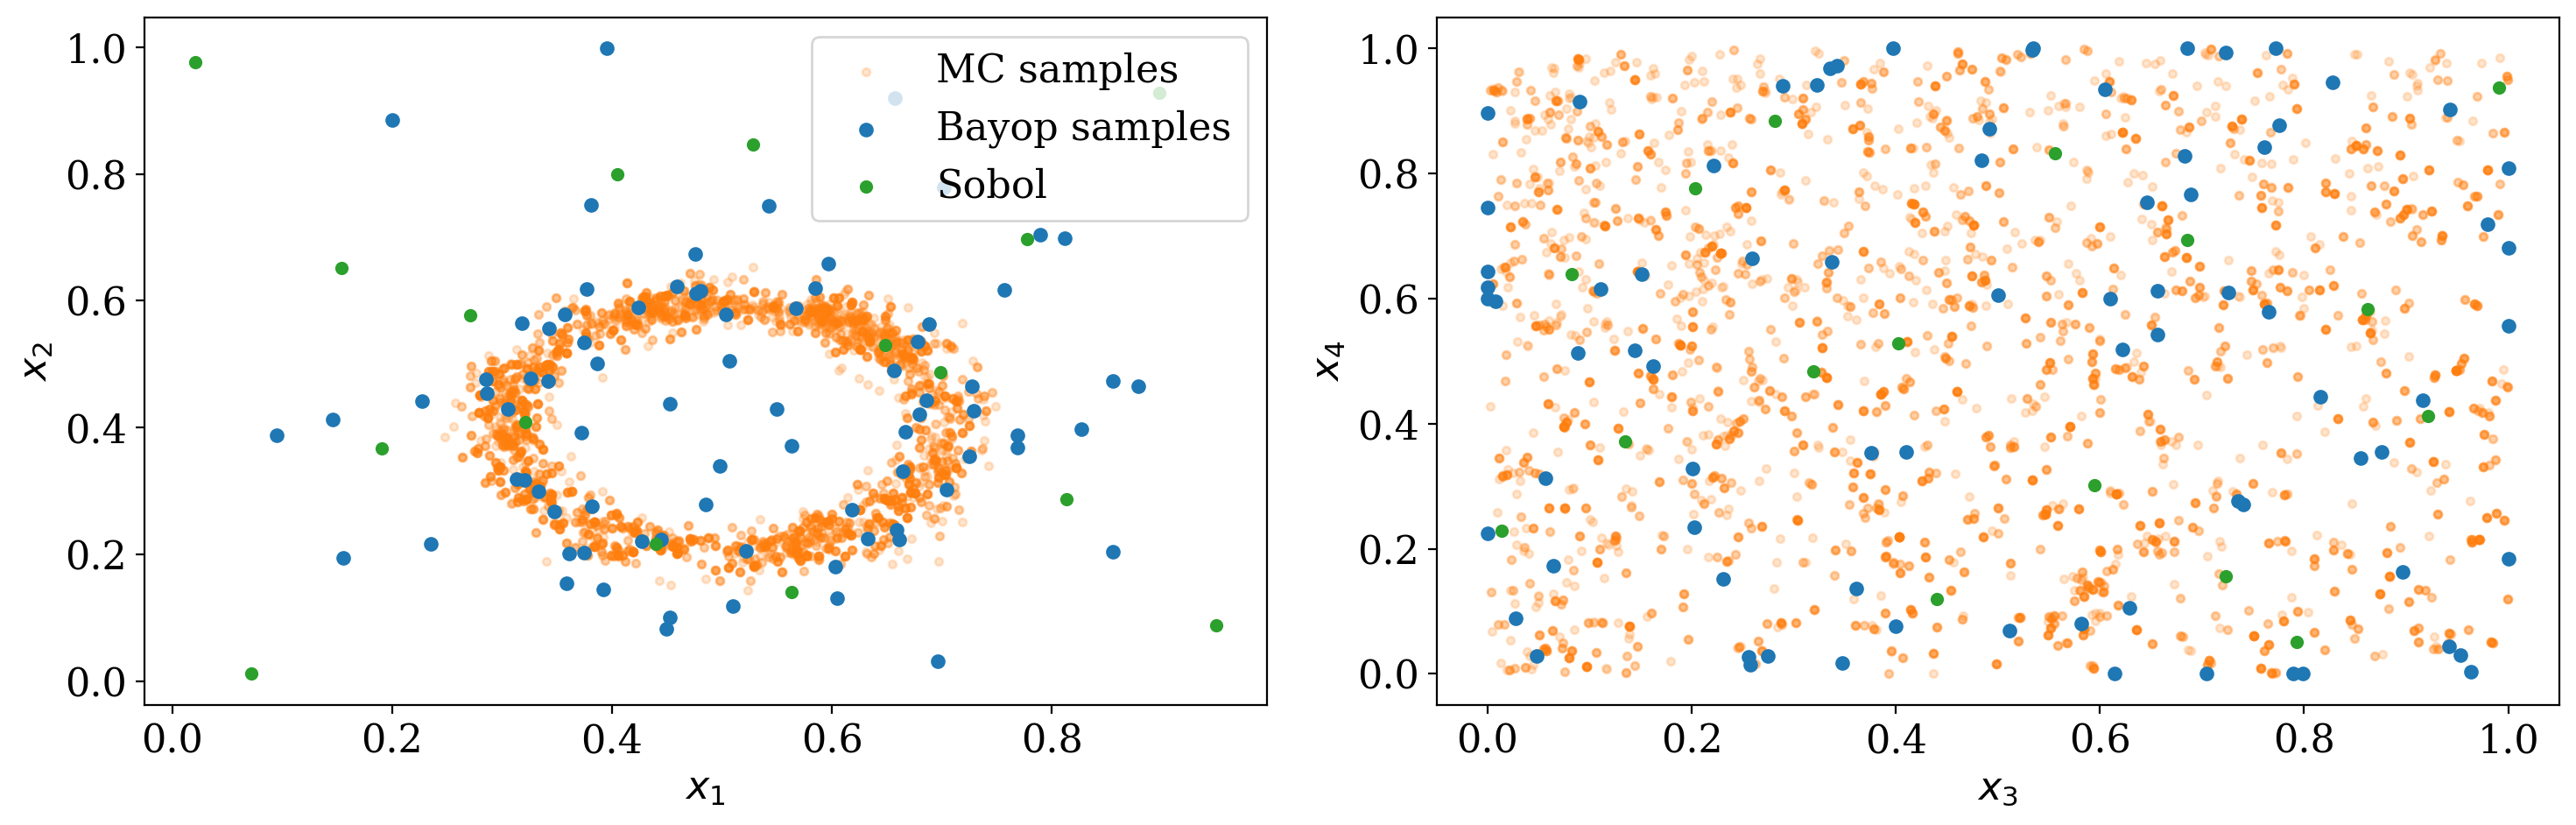

In [5]:
fig,ax = plt.subplots(1,int(ndim/2),figsize=(15,5))
for i,x in enumerate(ax):
    x.scatter(samples[:,2*i],samples[:,2*i+1],s=10,label='MC samples',color='C1',alpha=0.2)
    x.scatter(train_x[ninit:,2*i],train_x[ninit:,2*i+1],s=25,label='Bayop samples',color='C0')
    x.scatter(train_x[:ninit,2*i],train_x[:ninit,2*i+1],s=20,label='Sobol',color='C2')
    x.set_ylabel(r'$x_{{%i}}$'%(2*i+2))
    x.set_xlabel(r'$x_{{{}}}$'.format(2*i+1))
    # x.axvline(f_mean[2*i],ls='-.',color='k')
    # x.axhline(f_mean[2*i + 1],ls='-.',color='k')
ax[0].legend()
fig.tight_layout()

In [8]:
print(gp.get_median_lengthscales())

[  0.19469207   0.19166252 173.99668493 163.22567955]


In [6]:
samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.01,num_samples_equal=3000,difficult_model=True)
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

Nested Sampling took 10.66s
jaxns did 400873 likelihood evaluations
LogZ logz_mean: -2.5717, dlogz: 0.1367, 


Removed no burn in
Removed no burn in


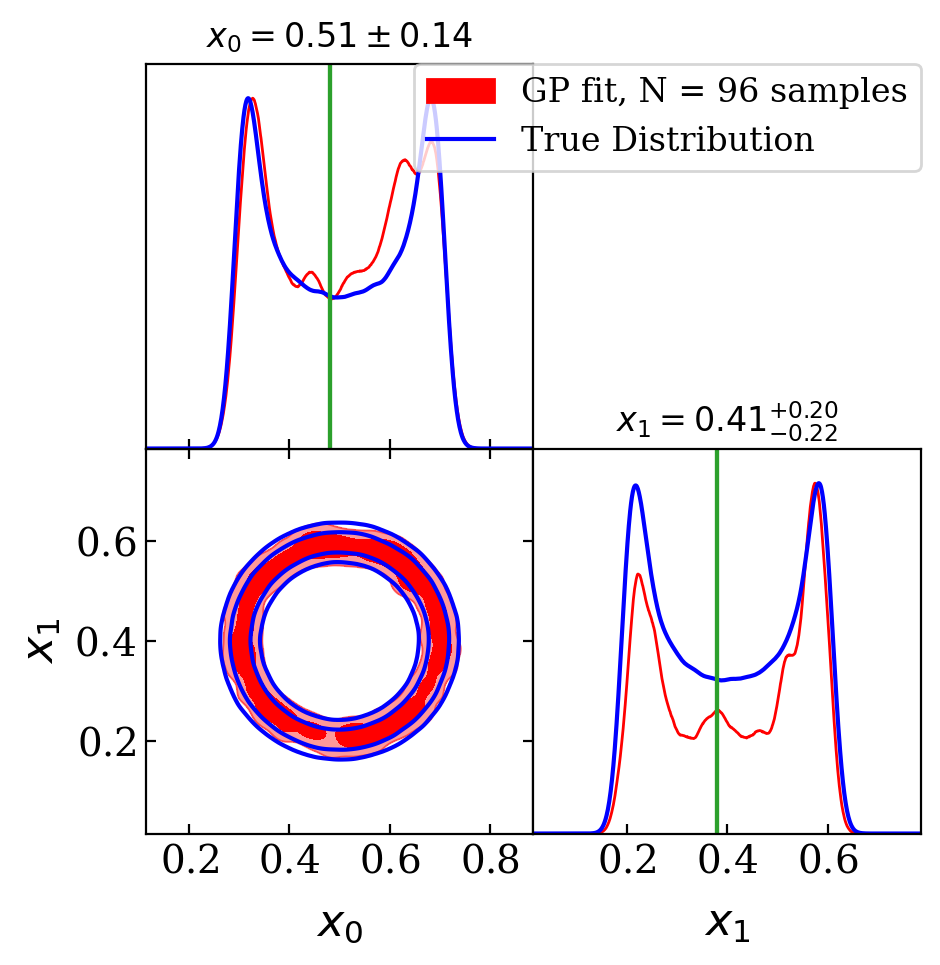

In [7]:
size = int(5e5)
rs = np.random.normal(loc=mean_r,scale=scale,size=size)
thetas = 2*np.pi*np.random.rand(size)
xs = abs(rs)*np.cos(thetas)+0.5
ys = abs(rs)*np.sin(thetas)+0.4
xys = np.array([xs,ys]).T

labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  np.array(ndim*[[0,1]])
true_samples = MCSamples(samples=xys,names=names[:2], labels = labels[:2],ranges=ranges[:2]) # a comparison run
gp_samples = MCSamples(samples=samples[::4],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=2.5,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 14
g.settings.title_limit_fontsize = 14
g.triangle_plot([gp_samples,true_samples], names[:2],filled=[True,False],contour_colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} samples','True Distribution'],
                                contour_lws=[1,1.5],title_limit=1,)
                                # markers = dict(zip(names[:2],[0.])),
                                # marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'}) # type: ignore

locs = np.array([0.5,0.4])
for i in range(2):
    ax = g.subplots[i,i]
    ax.axvline(locs[i]-scale, color='C2', ls='-')
    ax.axvline(locs[i]-scale, color='C2', ls='-')


